# 1) Histogram Equalisation

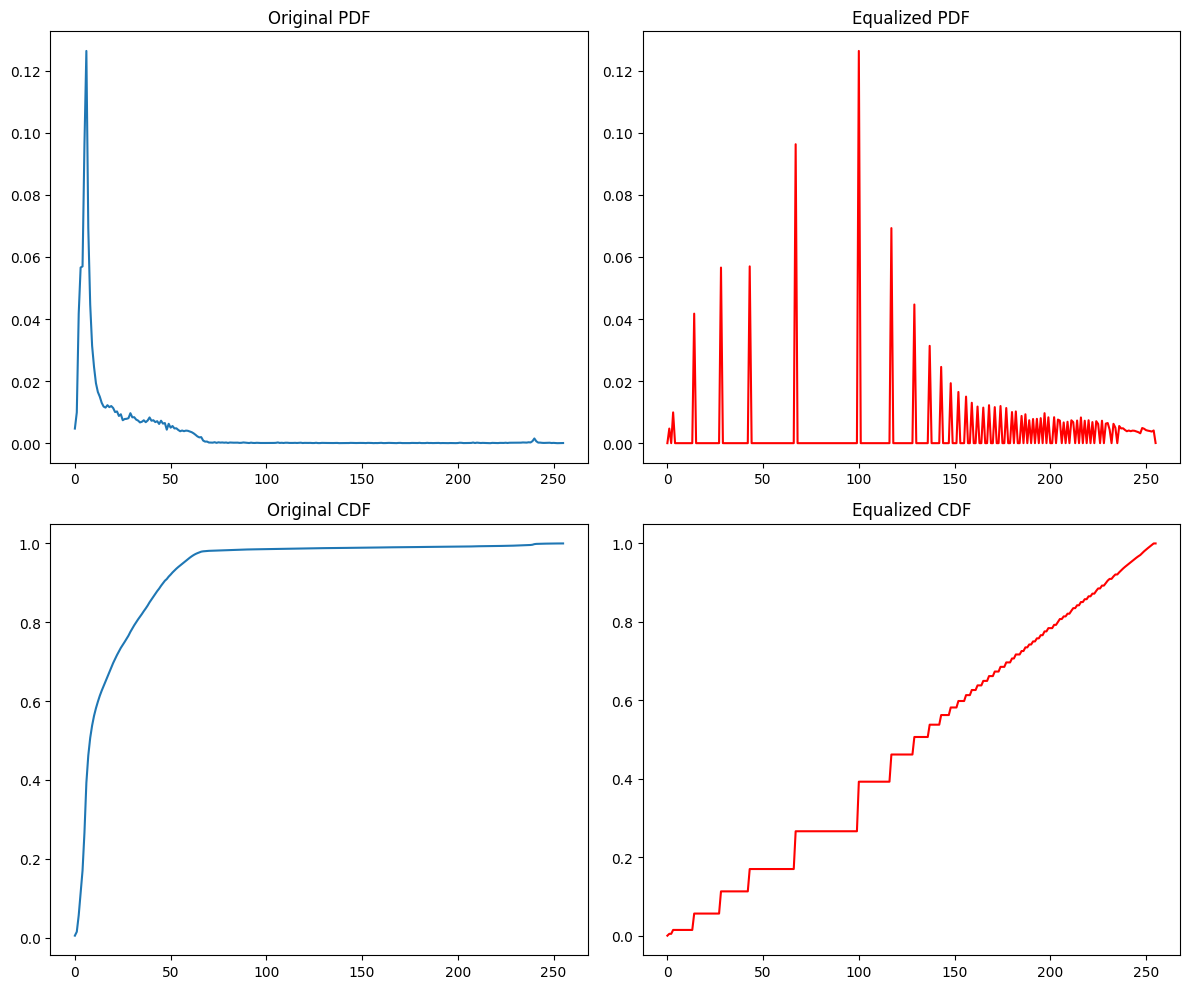

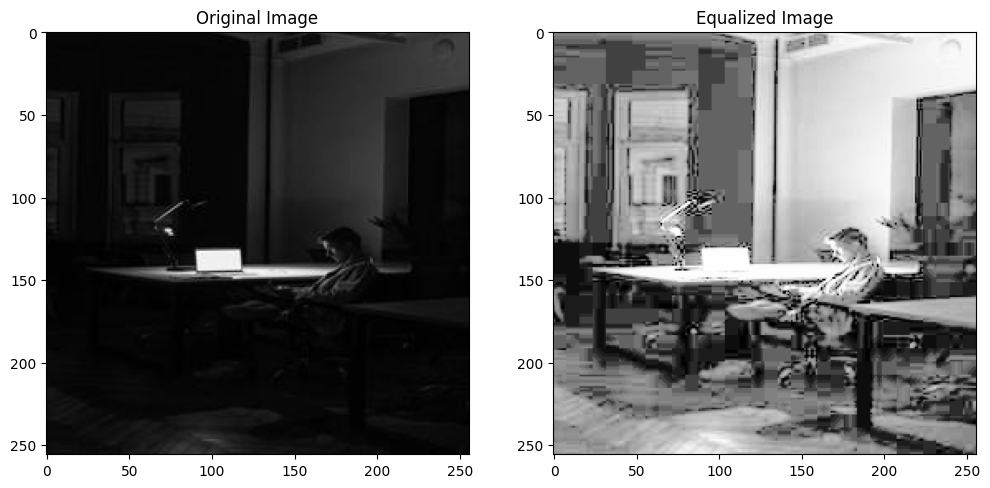

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

# Creating PDF
def create_pdf(im_in):
    histogram, _ = np.histogram(im_in.flatten(), bins=256, range=[0, 256]) #Flattening the image
    pdf = histogram / np.sum(histogram)
    return pdf

# Creating CDF
def create_cdf(pdf):
    return np.cumsum(pdf)

# Histogram Equalization function utilizing create_pdf and create_cdf functions.
def histogram_equalization(im_in):
    pdf = create_pdf(im_in)
    cdf = create_cdf(pdf)
    cdf_normalized = cdf * 255
    im_equalized = np.interp(im_in.flatten(), range(256), cdf_normalized).reshape(im_in.shape)
    return im_equalized.astype(np.uint8)

image = io.imread('/content/detective.png', as_gray=True)

# Calling histogram equalization function
equalized_image = histogram_equalization(image)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

pdf_original = create_pdf(image)
cdf_original = create_cdf(pdf_original)
pdf_equalized = create_pdf(equalized_image)
cdf_equalized = create_cdf(pdf_equalized)

# Displaying the graphs.
axs[0, 0].plot(pdf_original)
axs[0, 0].set_title('Original PDF')
axs[0, 1].plot(pdf_equalized, color = 'red')
axs[0, 1].set_title('Equalized PDF')
axs[1, 0].plot(cdf_original)
axs[1, 0].set_title('Original CDF')
axs[1, 1].plot(cdf_equalized, color = 'red')
axs[1, 1].set_title('Equalized CDF')

plt.tight_layout()
plt.show()

# Displaying the original and equalized images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image')
ax2.imshow(equalized_image, cmap='gray')
ax2.set_title('Equalized Image')
plt.show()

### 1) Brief introduction of histogram of an image and what it does.

A histogram of an image is a graphical representation of the distribution of pixel intensities within that image.

An image histogram plots the number of pixels for each intensity value, typically ranging from 0 (black) to 255 (white) for an 8-bit grayscale image. The x-axis represents the intensity values, while the y-axis shows the pixel count for each intensity.

Image histograms have several purposes:
* They provide a quick visual summary of the image's tonal distribution.
* They help in assessing image contrast and brightness.
* They are useful for identifying under- or over-exposed areas in the image.
* They form the basis for various image processing techniques, including histogram equalization, which can enhance image contrast by redistributing pixel intensities more evenly across the available range1.

Understanding image histograms is crucial for many computer vision and image processing tasks, as they offer insights into the image's characteristics and can guide further analysis or enhancement procedures.


### 2) Provide a comparative discussion of the PDF and CDF plots, and relate them to the image’s contrast and intensity.

* The PDF of the original image shows peaks corresponding to the dominant brightness levels, with a large peak for the bright laptop screen. After equalization, the PDF appears more spread out across the intensity range, indicating a more balanced distribution of pixel intensities.

* The original CDF has steep sections where many pixels share similar intensities. The equalized CDF appears closer to a straight line after, indicating a more uniform distribution of intensities.

* The equalization process stretches out the intensity range, effectively **enhancing the image's overall contrast**. This is evident in the more distributed PDF and the linearized CDF of the equalized image.

* Areas of the original image with low contrast are expanded in the equalized image, **distributing the intensity.** This reveals hidden details, particularly in the darker regions of the image.

* The bright laptop screen, which dominated the original image, should have relatively less brightness in the equalized version, resulting in a bright area adjustment.

The equalization process stretches out the intensity range, effectively increasing the image's contrast. Areas of the original image with low contrast are expanded, revealing previously hidden details. The bright laptop screen, which dominated the original image, should have less relative brightness in the equalized version, allowing other elements to become more visible.

By applying this histogram equalization technique, we enhance the contrast of the image, potentially revealing what the person is sitting on.

**After enhancing the image, we could say that the person is sitting on a low-back office chair with wheels and with one leg on top of the other.**

# 2) Image Thresholding

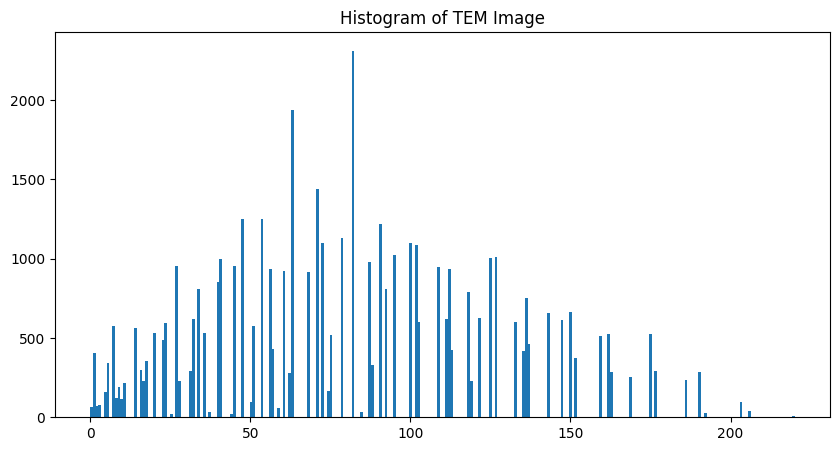

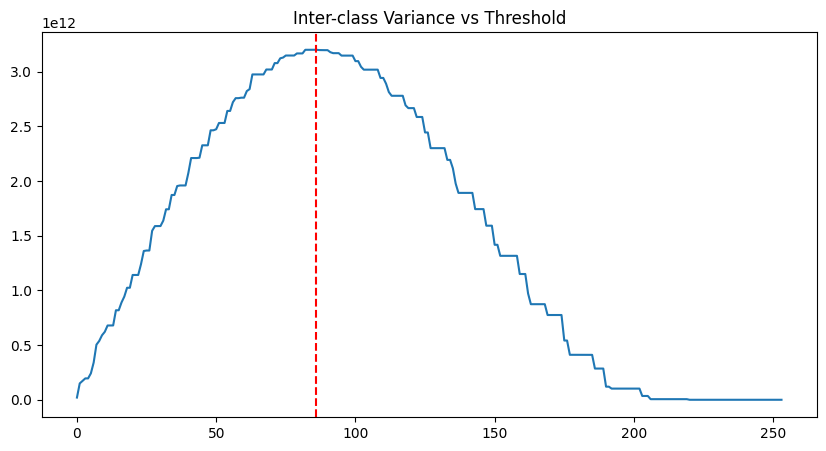

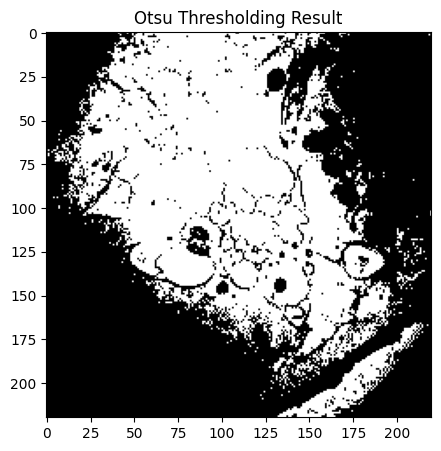

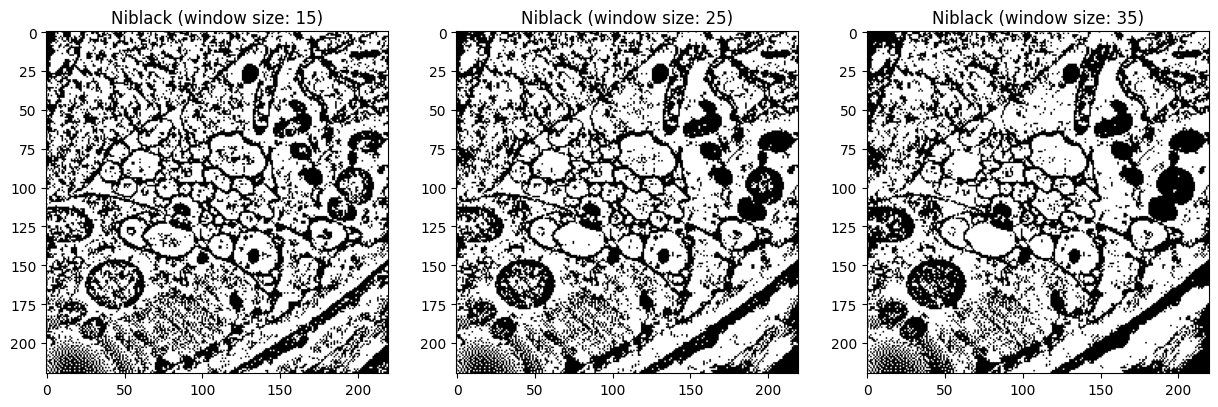

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

# Funtion for Otsu Thresholding
def otsu_thresholding(image):
    hist, bin_edges = np.histogram(image.flatten(), bins=256, range=[0, 256]) #Creating Histogram
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2 # Calculating Bin Centers

    variances = []
    for t in range(1, 255):
        w0 = np.sum(hist[:t])
        w1 = np.sum(hist[t:])

        if w0 == 0 or w1 == 0:
            variances.append(0)
            continue
# The loop iterates through possible thresholds (1-254) and calculates the weights of the two classes separated by the threshold.

        mu0 = np.sum(hist[:t] * bin_centers[:t]) / w0
        mu1 = np.sum(hist[t:] * bin_centers[t:]) / w1

        variance = w0 * w1 * (mu0 - mu1) ** 2
        variances.append(variance)

# To calculate the means of the two classes and the inter-class variance, which is appended to the variances list.

    return np.argmax(variances) + 1, variances  #Returning - 1) threshold that maximizes the inter-class variance and 2) list of variances.

# Function for Ni-Black Thresholding
def niblack_thresholding(image, window_size, k=-0.2): # Taking k value as suggested in the paper.
    pad = window_size // 2
    padded_image = np.pad(image, pad, mode='reflect') # Padding the image to handle edge cases.

    mean = np.zeros_like(image, dtype=float)
    std = np.zeros_like(image, dtype=float)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            window = padded_image[i:i+window_size, j:j+window_size]
            mean[i, j] = np.mean(window)
            std[i, j] = np.std(window)

# The nested loop calculates the local mean and standard deviation for each pixel with specified window size.

    threshold = mean + k * std
    return image > threshold


# Load the image
image = io.imread('/content/TEM cell.png', as_gray=True)

# Printing histogram
plt.figure(figsize=(10, 5))
plt.hist(image.ravel(), bins=256)
plt.title('Histogram of TEM Image')
plt.show()

# Calling Otsu's thresholding
otsu_threshold, variances = otsu_thresholding(image)
otsu_binary = image > otsu_threshold

plt.figure(figsize=(10, 5))
plt.plot(variances)
plt.title('Inter-class Variance vs Threshold')
plt.axvline(x=otsu_threshold, color='r', linestyle='--')
plt.show()
# Plotting the inter-class variance vs threshold and marked the chosen Otsu threshold.

plt.figure(figsize=(10, 5))
plt.imshow(otsu_binary, cmap='gray')
plt.title('Otsu Thresholding Result')
plt.show()
#Displaying the Image after otsu thresholding

# Calling Niblack thresholding and plotting with 3 windows
window_sizes = [15, 25, 35]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, size in enumerate(window_sizes):
    niblack_binary = niblack_thresholding(image, size)
    axs[i].imshow(niblack_binary, cmap='gray')
    axs[i].set_title(f'Niblack (window size: {size})')
plt.show()

### 1) Show the binary image after thresholding and discuss the results. Explain why do you think the results are they way they are.

* After applying Otsu's thresholding to the TEM image, the resulting binary image typically shows distinct cell boundaries as white regions against a black background.
* The method calculates a single threshold for the entire image, **a global threshold,** which may not effectively segment regions with varying illumination.
* Variations in brightness due to imaging defects may lead to inconsistent segmentation, causing some structures to be underrepresented or lost.
* The complex structure of TEM image may complicate thresholding, as a single threshold may not adequately separate all features.
* The presence of noise may lead to distortions in the binary image, resulting in isolated white pixels in areas that should be background.

Overall, while Otsu's thresholding provides a reasonable segmentation, adaptive methods like Niblack may yield better results for images with non-uniform illumination and complex structures.

### 2) Comparatively discuss the two thresholding based on the results you got.

* Otsu's thresholding method attempts to find a global threshold that separates the image into foreground and background. The results may not be ideal for this TEM image due to the non-uniform illumination and complex structures present.
* Niblack's thresholding adapts to local image characteristics, which can be beneficial for images with varying illumination. The different window sizes affect the local statistics used for thresholding:
* * Smaller windows capture more local detail but may be sensitive to noise.
* * Larger windows provide more stable thresholds but may miss fine details.
* Niblack's method generally performs better on this TEM image as it can adapt to local intensity variations, potentially enhancing cell boundaries more effectively than Otsu's global threshold.

# 3) Template Matching

<ipython-input-6-d44e95f2bae9>:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


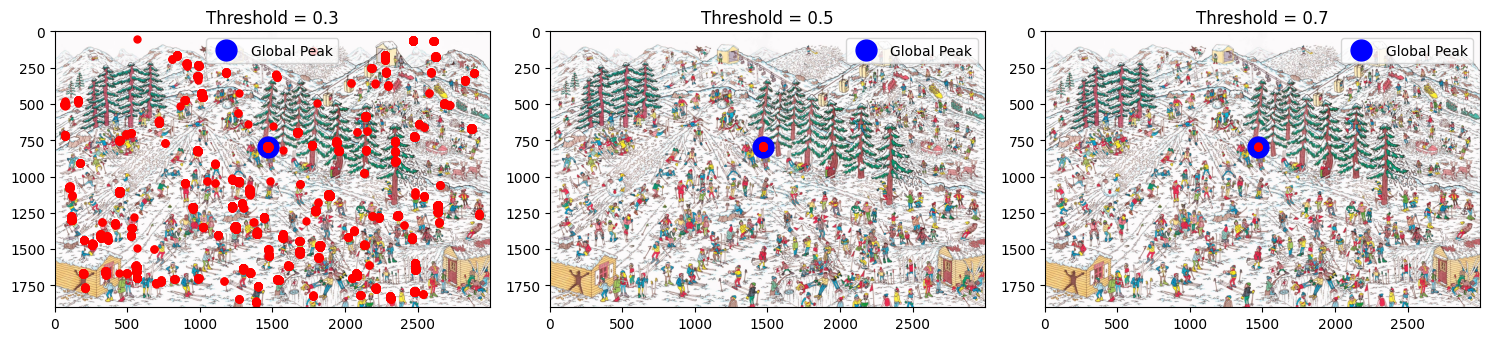

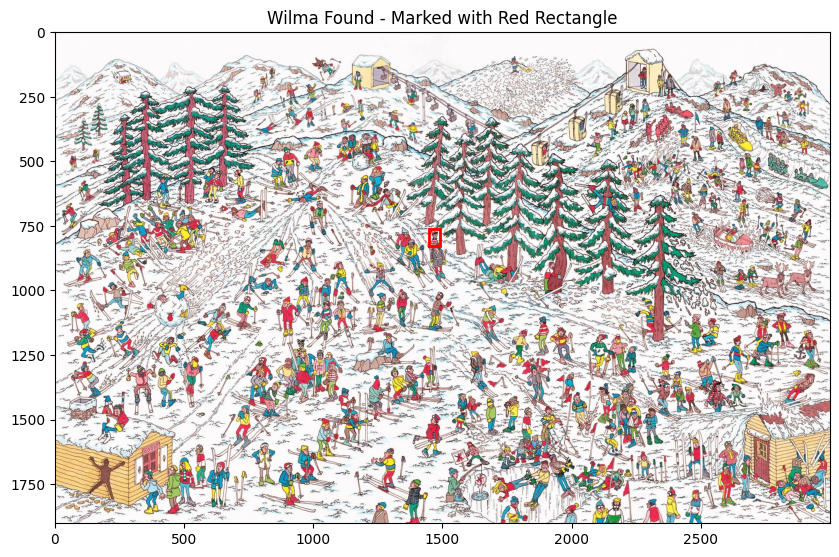

Execution Time: 574.6520 seconds


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from scipy import signal
import time

# Normalized Cross-Correlation Funtion
def normalized_cross_correlation(image, template):
    if image.ndim == 3:
        image = np.mean(image, axis=2)  # Convert to grayscale
    if template.ndim == 3:
        template = np.mean(template, axis=2)  # Convert to grayscale

    image_height, image_width = image.shape
    template_height, template_width = template.shape

    result = np.zeros((image_height - template_height + 1, image_width - template_width + 1))

    template_mean = np.mean(template)
    template_std = np.std(template)

    for y in range(result.shape[0]):
        for x in range(result.shape[1]):
            window = image[y:y+template_height, x:x+template_width]
            window_mean = np.mean(window)
            window_std = np.std(window)

            if window_std > 0 and template_std > 0:
                result[y, x] = np.mean(
                    ((window - window_mean) / window_std) *
                    ((template - template_mean) / template_std)
                )
            else:
                result[y, x] = 0

    return result

image = io.imread('/content/snow.jpg')
template = io.imread('/content/snowtemp.jpg')

# To Measure execution time of template matching
start_time = time.time()  # Start timer

# Performing Template Matching
correlation = normalized_cross_correlation(image, template)

end_time = time.time()  # End timer
execution_time = end_time - start_time  # Calculate execution time

# Maximum peak (global maximum)
max_y, max_x = np.unravel_index(np.argmax(correlation), correlation.shape)

peak_x = max_x + template.shape[1] // 2
peak_y = max_y + template.shape[0] // 2

# Thresholding for non-maximum peaks
thresholds = [0.3, 0.5, 0.7]

# Mark the global peak and other peaks on thresholded cross-correlation
plt.figure(figsize=(15, 5))
for i, threshold in enumerate(thresholds):
    plt.subplot(1, 3, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Threshold = {threshold}')

    # Identify peaks greater than the threshold
    thresholded_correlation = correlation > threshold

    # Mark the global peak
    plt.plot(peak_x, peak_y, 'bo', markersize=15, label = "Global Peak")

    # Mark other peaks
    non_max_peaks = np.where(thresholded_correlation)
    for y, x in zip(non_max_peaks[0], non_max_peaks[1]):
        plt.plot(x + template.shape[1] // 2, y + template.shape[0] // 2, 'ro', markersize=5)

    plt.legend()

plt.tight_layout()
plt.show()

# Overlay result on original image with the rectangle around the matched template
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(image)
rect = plt.Rectangle((peak_x - template.shape[1]//2, peak_y - template.shape[0]//2),
                     template.shape[1], template.shape[0],
                     edgecolor='r', facecolor='none', linewidth=2)
ax.add_patch(rect)

plt.title("Wilma Found - Marked with Red Rectangle")
plt.show()

print(f"Execution Time: {execution_time:.4f} seconds")


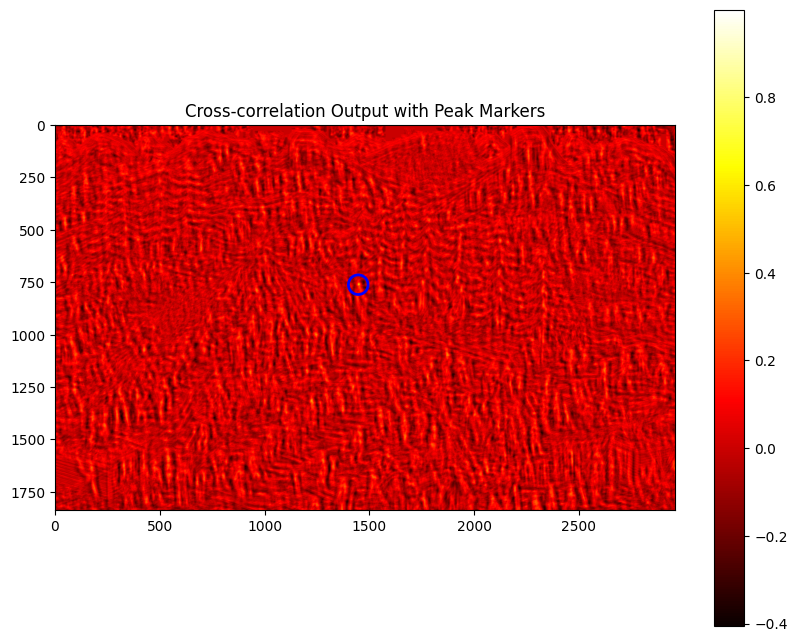

In [ ]:
# Displaying the cross-correlation output with peak markers
plt.figure(figsize=(10, 8))
plt.imshow(correlation, cmap='hot')
plt.colorbar()
plt.title('Cross-correlation Output with Peak Markers')

# Global peak
peak_y, peak_x = np.unravel_index(np.argmax(correlation), correlation.shape)
# Marking the peak with a blue circle
plt.scatter(peak_x, peak_y, s=200, edgecolor='blue', facecolor='none', linewidth=2)
plt.show()

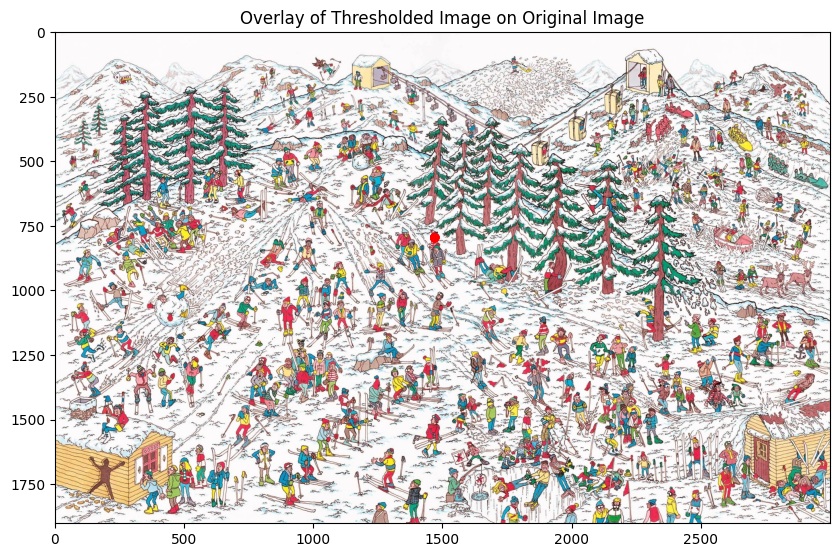

In [ ]:
# Displaying the thresholded image on top of the first image
thresholded_image = correlation > 0.5

# To overlay the thresholded image
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(image)

# Creating a mask for the thresholded areas
mask_y, mask_x = np.where(thresholded_image)
for y, x in zip(mask_y, mask_x):
    ax.plot(x + template.shape[1] // 2, y + template.shape[0] // 2, 'ro', markersize=5)

plt.title("Overlay of Thresholded Image on Original Image")
plt.show()

## Q1) Discuss if this location matches your expectations.
In the normalised cross-correlation output, the global peak aligns with the spot where the template matches best in the original image. In this case, the global peak did match location of the template accurately as expected.

## Q2) Discuss the appearance and cause of other peaks, and how they compare to the global peak, you may just manually check other peaks and annotate them on the peak image.
Other peaks in the correlation image may arise in regions that share some similarities with the template but are not exact matches.
These secondary peaks could be caused by repetitive patterns or noise in the image. They will generally have lower correlation scores compared to the global peak.


# 4) Creative Section

Execution Time: 6.9136 seconds


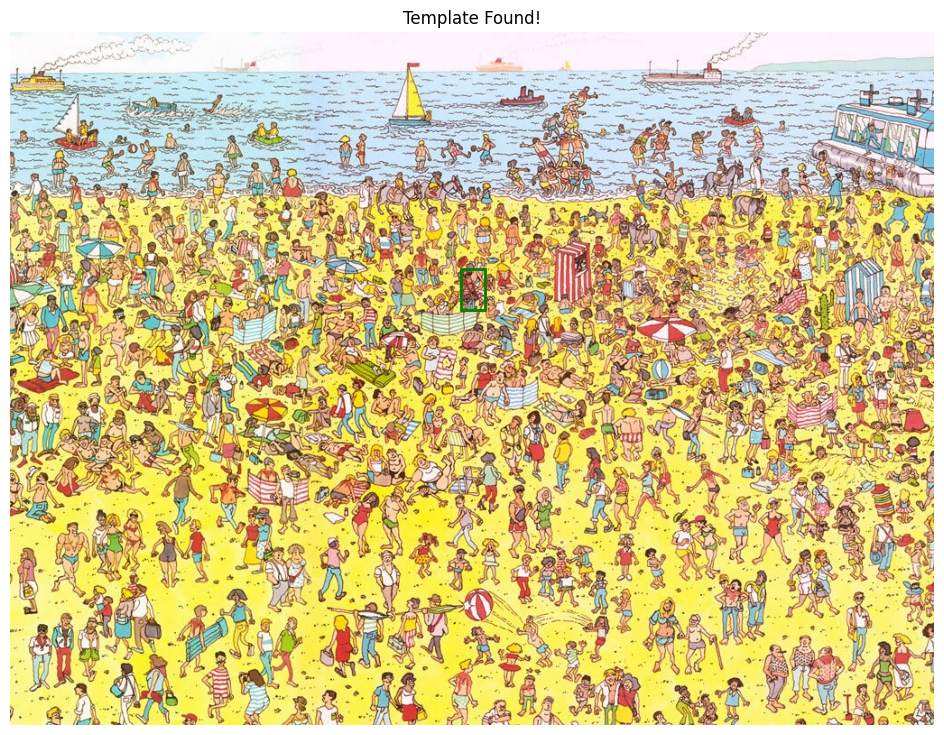

In [ ]:
import numpy as np
from skimage import io, color
import matplotlib.pyplot as plt
import time

# To compute the integral image.
def compute_integral_image(image):
    integral_image = np.zeros((image.shape[0] + 1, image.shape[1] + 1))
    integral_image[1:, 1:] = np.cumsum(np.cumsum(image, axis=0), axis=1)
    return integral_image

# To get the sum of the rectangle from the integral image.
def get_sum(integral_image, top_left, bottom_right):
    x1, y1 = top_left
    x2, y2 = bottom_right
    return (integral_image[x2, y2] - integral_image[x1, y2] - integral_image[x2, y1] + integral_image[x1, y1])

#To calculate the Sum of Absolute Differences (SAD) score
def sad(image, template):
    image_height, image_width = image.shape
    template_height, template_width = template.shape

    integral_image = compute_integral_image(image)

    best_match = None
    best_score = np.inf

    for y in range(image_height - template_height + 1):
        for x in range(image_width - template_width + 1):
            region_sum = get_sum(integral_image, (y, x), (y + template_height, x + template_width))
            template_sum = np.sum(template)
            score = np.abs(region_sum - template_sum)

            if score < best_score:
                best_score = score
                best_match = (x, y, template_width, template_height)

    return best_match

# Template Matching (To make the code just accept 2 images)
def template_matching(original_image_path, template_image_path):
    image = io.imread(original_image_path)
    template = io.imread(template_image_path)

    # Converting to grayscale
    image_gray = color.rgb2gray(image) if image.ndim == 3 else image
    template_gray = color.rgb2gray(template) if template.ndim == 3 else template

    start_time = time.time()# Start the timer

    # To find the template in the original image
    match = sad(image_gray, template_gray)

    end_time = time.time()  #End the timer

    # Execution time
    execution_time = end_time - start_time
    print(f"Execution Time: {execution_time:.4f} seconds")

    # Return the bounding box coordinates
    return match

# Function to display result
def display_result(original_image_path, match):
    image = io.imread(original_image_path)
    start_x, start_y, width, height = match
    plt.figure(figsize=(12, 9))
    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle((start_x, start_y), width, height,
                                          fill=False, edgecolor='green', linewidth=2))
    plt.title('Template Found!')
    plt.axis('off')
    plt.show()


original_image_path = '/content/WaldoBeach.jpg'
template_image_path = '/content/WaldoBeachtemp.jpg'
match = template_matching(original_image_path, template_image_path)
display_result(original_image_path, match)
